# Machine Learning with PyTorch

## Tasks with Networks

<font size="+1">A simple feature classifier</font>
<a href="NetworkExamples_0.ipynb"><img src="img/open-notebook.png" align="right"/></a>

<font size="+1"><u><b>An image classifier</b></u></font>
<a href="NetworkExamples_1.ipynb"><img src="img/open-notebook.png" align="right"/></a>

<font size="+1">A regression prediction</font>
<a href="NetworkExamples_2.ipynb"><img src="img/open-notebook.png" align="right"/></a>

<font size="+1">Clustering with NNs</font>
<a href="NetworkExamples_3.ipynb"><img src="img/open-notebook.png" align="right"/></a>

<font size="+1">Generative Adversarial Networks (GAN)</font> 
<a href="NetworkExamples_4.ipynb"><img src="img/open-notebook.png" align="right"/></a>

<font size="+1">Reinforcement Learning</font>
<a href="NetworkExamples_5.ipynb"><img src="img/open-notebook.png" align="right"/></a>

In [1]:
%matplotlib inline
from statistics import mean
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.nn import Sequential, Conv2d, MaxPool2d, Linear, Module
import torch.optim as optim

# For demonstration, we can use CPU target if CUDA not available
device = torch.device('cpu')

# Check the status of the GPU (if present)
if torch.cuda.is_available():
    print("CUDA memory used:", torch.cuda.memory_allocated())
    device = torch.device('cuda') 

CUDA memory used: 0


## An image classifier

To get a feel for an image classifier, let us setup one very close to that presented in the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).  We will change a few details and add some commentary, but most of the code follows that.

The output of torchvision datasets are PILImage images of range `[0, 1]`. We transform them to Tensors of normalized range `[-1, 1]`.

In [2]:
batch_size = 16
transform = Compose([
    Resize(32),
    ToTensor(),
    Normalize((0, 0, 0), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


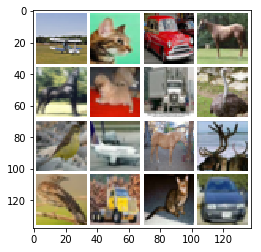

Labels: plane cat car horse horse dog truck bird bird plane horse deer bird truck cat car


In [18]:
# Function to show an image
def imshow(images):
    grid = make_grid(images, padding=2, pad_value=2, nrow=4)
    grid /= 2     # unnormalize
    npimg = grid.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images and labels
imshow(images)
print('Labels:', ' '.join(classes[labels[j]] for j in range(batch_size)))

The PyTorch tutorial uses a more object-oriented style than shown.  I prefer the more declarative (and more concise) style of `torch.nn.Sequential`.  The OOP style requires a separate `.__init__()` method to configure layers, then a `.forward()` to actually utilize them.  To me, this feels excessively imperative and bug-prone.

```python
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
```

Unfortunately, the developers of PyTorch currently endorse the OOP style, and to that end of removed `torch.nn.View` as a separate declarative layer, making reshaping in layers more difficult.  We can work around that by creating our own `Flatten` layer.

In [4]:
class Flatten(Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape
   
    def forward(self, x):
        return x.view(-1, self.shape) 
    
    def __repr__(self):
        return f"{self.__class__.__name__}({self.shape})"

In [5]:
model = Sequential(
    Conv2d(3, 6, 5),
    MaxPool2d(2, 2),
    Conv2d(6, 16, 5),
    MaxPool2d(2, 2),
    Flatten(400),
    Linear(400, 120),
    Linear(120, 84),
    Linear(84, 10)
).to(device)
model

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Flatten(400)
  (5): Linear(in_features=400, out_features=120, bias=True)
  (6): Linear(in_features=120, out_features=84, bias=True)
  (7): Linear(in_features=84, out_features=10, bias=True)
)

In [6]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [7]:
%%time
running_loss = []
# loop over the dataset multiple times
for epoch in range(1, 3):  
    for batch, data in enumerate(trainloader, 0):
        # get the inputs, put them on GPU if available
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        running_loss.append(loss.item())
        loss.backward()
        optimizer.step()

        # print statistics
        if batch % 500 == 499:    # print every 2000 mini-batches
            print(f'Epoch {epoch}; Batch {batch+1} '
                  f'- Running-Loss: {mean(running_loss[-2000:])}')

Epoch 1; Batch 500 - Running-Loss: 2.239190950393677
Epoch 1; Batch 1000 - Running-Loss: 2.0956314018964766
Epoch 1; Batch 1500 - Running-Loss: 2.010363760391871
Epoch 1; Batch 2000 - Running-Loss: 1.9398647089004517
Epoch 1; Batch 2500 - Running-Loss: 1.8000764474868773
Epoch 1; Batch 3000 - Running-Loss: 1.7219618119597435
Epoch 2; Batch 500 - Running-Loss: 1.643363942027092
Epoch 2; Batch 1000 - Running-Loss: 1.5996985107958317
Epoch 2; Batch 1500 - Running-Loss: 1.5602097700834274
Epoch 2; Batch 2000 - Running-Loss: 1.5339805231094361
Epoch 2; Batch 2500 - Running-Loss: 1.5147200609445572
Epoch 2; Batch 3000 - Running-Loss: 1.4986493615508079
CPU times: user 16.7 s, sys: 2.91 s, total: 19.6 s
Wall time: 20.7 s


In [8]:
dataiter = iter(testloader)

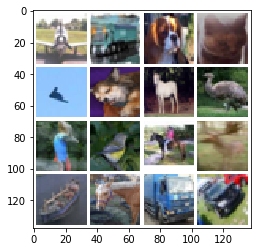

  Truth: plane truck dog   cat   plane dog   horse bird  bird  bird  horse deer  ship  horse truck car   
Predict: truck car   dog   frog  plane frog  horse car   bird  frog  horse deer  ship  truck ship  bird  


In [19]:
images, labels = dataiter.next()

# Print images and ground truth
imshow(images)
print('  Truth:', ''.join(f'{classes[labels[j]]:6}' for j in range(batch_size)))

# The predictions
outputs = model(images.to(device))
_, predict = torch.max(outputs.data, 1)
print('Predict:', ''.join(f'{classes[predict[j]]:6}' for j in range(batch_size)))

In [20]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 47 %
